# Imports 

In [1]:
import sqlite3
import pandas as pd
from datetime import datetime

In [2]:
DB_FILE = "rta_snapshot.db"
engine = sqlite3.connect(DB_FILE)

# Get Data

In [3]:
df = pd.read_sql("select * from battle_logs", engine)

# Clean + Enrich Data

In [4]:
# number of records
df.shape

(58958, 25)

In [5]:
# unique leages
df["P1_LEAGUE"].unique().tolist()

['gold', 'master', 'silver', 'champion', 'challenger', 'bronze', 'legend']

In [6]:
# add win rate + total matches columns

cols = ["P1_WINS", "P1_LOSSES", "P2_WINS", "P2_LOSSES"]
for col in cols:
    df[col] = df[col].astype(int)

In [7]:
# Add some additional columns that might be useful

df["P1_MATCHES"] = df["P1_WINS"] + df["P1_LOSSES"]
df["P2_MATCHES"] = df["P2_WINS"] + df["P2_LOSSES"]

df["P1_WINRATE"] = df["P1_WINS"] / df["P1_MATCHES"]
df["P2_WINRATE"] = df["P2_WINS"] / df["P2_MATCHES"]

df["WINRATE_DELTA"] = df["P1_WINRATE"] - df["P2_WINRATE"]
df["WINRATE_DELTA"] = df["WINRATE_DELTA"].apply(abs)

df["CREATED"] = df["CREATED"].astype(int)
df["TIME"] = df["CREATED"].apply(datetime.fromtimestamp)

In [8]:
# Get actual team of each player
def get_func(p1=True):
    def get_team(row, p1=p1):
        if p1:
            player = "P1"
            opponent = "P2"
        else:
            player = "P2"
            opponent = "P1"
        team = []
        for i in range(1,6):
            team += [row[f"{player}_PICK{i}"]]
        team = [i for i in team if i != row[f"{opponent}_POSTBAN"]]
        return ",".join(team)
    return get_team

get_p1_team = get_func(True)
get_p2_team = get_func(False)

In [9]:
# generate full team as str
df["P1_TEAM"] = df.apply(get_p1_team, axis=1)
df["P2_TEAM"] = df.apply(get_p2_team, axis=1)

In [10]:
# add match_id
df["match_id"] = df.index

In [11]:
# get win as bool
df["WIN_LOSE"] = df["WIN_LOSE"].astype(int)
df["WIN"] = df["WIN_LOSE"].map({1: True, -1: False})

In [12]:
df.columns

Index(['CREATED', 'WIN_LOSE', 'SCORE', 'P1_SERVER', 'P2_SERVER', 'P1_PREBAN',
       'P2_PREBAN', 'P1_POSTBAN', 'P2_POSTBAN', 'P1_PICK1', 'P1_PICK2',
       'P1_PICK3', 'P1_PICK4', 'P1_PICK5', 'P2_PICK1', 'P2_PICK2', 'P2_PICK3',
       'P2_PICK4', 'P2_PICK5', 'P1_LEAGUE', 'P2_LEAGUE', 'P1_WINS',
       'P1_LOSSES', 'P2_WINS', 'P2_LOSSES', 'P1_MATCHES', 'P2_MATCHES',
       'P1_WINRATE', 'P2_WINRATE', 'WINRATE_DELTA', 'TIME', 'P1_TEAM',
       'P2_TEAM', 'match_id', 'WIN'],
      dtype='object')

In [13]:
# player agnostic index columns
idx_cols = ["match_id", "CREATED", "TIME", "SCORE", "WIN_LOSE", "WIN", "WINRATE_DELTA"]

In [14]:
cols = idx_cols + [i for i in df.columns if i not in idx_cols]

In [15]:
# final cleaned dataset
df = df[cols]

In [16]:
df.head()

,match_id,CREATED,TIME,SCORE,WIN_LOSE,WIN,WINRATE_DELTA,P1_SERVER,P2_SERVER,P1_PREBAN,...,P1_WINS,P1_LOSSES,P2_WINS,P2_LOSSES,P1_MATCHES,P2_MATCHES,P1_WINRATE,P2_WINRATE,P1_TEAM,P2_TEAM
0,0,1611835293,2021-01-28 07:01:33,1447,-1,False,0.158974,world_kor,world_asia,Cerise,...,49,68,26,19,117,45,0.418803,0.577778,"Fairytale Tenebria,Ruele of Light,General Purr...","Falconer Kluri,Champion Zerato,Apocalypse Ravi..."
1,1,1611828735,2021-01-28 05:12:15,1456,-1,False,0.103902,world_kor,world_kor,Cerise,...,49,67,40,36,116,76,0.422414,0.526316,"Fairytale Tenebria,General Purrgis,Remnant Vio...","Fallen Cecilia,Sage Baal & Sezan,Roana,Ravi,Bl..."
2,2,1611828331,2021-01-28 05:05:31,1465,-1,False,0.397442,world_kor,world_global,Cerise,...,49,66,14,3,115,17,0.426087,0.823529,"Fairytale Tenebria,General Purrgis,Remnant Vio...","Falconer Kluri,Sage Baal & Sezan,Fighter Maya,..."
3,3,1611828114,2021-01-28 05:01:54,1474,1,True,0.106761,world_kor,world_global,Cerise,...,49,65,22,19,114,41,0.429825,0.536585,"Fairytale Tenebria,Remnant Violet,General Purr...","Fallen Cecilia,Arbiter Vildred,Basar,Kayron,Vi..."
4,4,1611827382,2021-01-28 04:49:42,1455,1,True,0.275221,world_kor,world_asia,Cerise,...,48,65,14,6,113,20,0.424779,0.700000,"Fairytale Tenebria,Ruele of Light,General Purr...","Arbiter Vildred,Tempest Surin,Charles,Fallen C..."


In [17]:
# dataset by player
P1 = df[idx_cols + [i for i in df.columns if "P1" in i]]
P2 = df[idx_cols + [i for i in df.columns if "P2" in i]]

In [18]:
pd.options.mode.chained_assignment = None
# P1 Win = P2 Lose and vice versa
P2["WIN"] = P2["WIN_LOSE"].map({1: False, -1: True})

In [19]:
P1.columns = [i.replace("P1_", "") for i in P1.columns]
P2.columns = [i.replace("P2_", "") for i in P2.columns]

In [20]:
P1.columns == P2.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [21]:
# Win/Lose is redundant
# Score is only relevant for P1
by_player = pd.concat([P1, P2]).sort_values("match_id").drop(["WIN_LOSE", "SCORE"], axis=1)

In [22]:
by_player.head()

,match_id,CREATED,TIME,WIN,WINRATE_DELTA,SERVER,PREBAN,POSTBAN,PICK1,PICK2,PICK3,PICK4,PICK5,LEAGUE,WINS,LOSSES,MATCHES,WINRATE,TEAM
0,0,1611835293,2021-01-28 07:01:33,False,0.158974,world_kor,Cerise,Remnant Violet,Fairytale Tenebria,Ruele of Light,General Purrgis,Remnant Violet,Seaside Bellona,gold,49,68,117,0.418803,"Fairytale Tenebria,Ruele of Light,General Purr..."
0,0,1611835293,2021-01-28 07:01:33,True,0.158974,world_asia,Cerise,Champion Zerato,Falconer Kluri,Champion Zerato,Apocalypse Ravi,Adventurer Ras,Arbiter Vildred,gold,26,19,45,0.577778,"Falconer Kluri,Champion Zerato,Apocalypse Ravi..."
1,1,1611828735,2021-01-28 05:12:15,False,0.103902,world_kor,Cerise,Remnant Violet,Fairytale Tenebria,General Purrgis,Remnant Violet,Ruele of Light,Tempest Surin,gold,49,67,116,0.422414,"Fairytale Tenebria,General Purrgis,Remnant Vio..."
1,1,1611828735,2021-01-28 05:12:15,True,0.103902,world_kor,Cerise,Fallen Cecilia,Fallen Cecilia,Sage Baal & Sezan,Roana,Ravi,Blood Moon Haste,gold,40,36,76,0.526316,"Fallen Cecilia,Sage Baal & Sezan,Roana,Ravi,Bl..."
2,2,1611828331,2021-01-28 05:05:31,False,0.397442,world_kor,Cerise,Fairytale Tenebria,Fairytale Tenebria,General Purrgis,Remnant Violet,Seaside Bellona,Ruele of Light,gold,49,66,115,0.426087,"Fairytale Tenebria,General Purrgis,Remnant Vio..."


In [23]:
by_player.shape

(117916, 19)

### Write Data

In [24]:
df.to_sql("battle_logs_enriched", engine, if_exists="replace", index=False)
by_player.to_sql("battle_logs_by_player", engine, if_exists="replace", index=False)

In [25]:
df.to_csv("battle_logs_enriched.csv", index=False)
by_player.to_csv("battle_logs_by_player.csv", index=False)

# Explore Data

### Get Data by League

In [26]:
# filter by league
legend = by_player[by_player["LEAGUE"] == "legend"]

In [27]:
legend.head()

,match_id,CREATED,TIME,WIN,WINRATE_DELTA,SERVER,PREBAN,POSTBAN,PICK1,PICK2,PICK3,PICK4,PICK5,LEAGUE,WINS,LOSSES,MATCHES,WINRATE,TEAM
223,223,1612661691,2021-02-06 20:34:51,True,0.041626,world_global,Fallen Cecilia,Ravi,Last Rider Krau,Blood Moon Haste,Seaside Bellona,Sage Baal & Sezan,Ravi,legend,320,204,524,0.610687,"Last Rider Krau,Blood Moon Haste,Seaside Bello..."
224,224,1612661398,2021-02-06 20:29:58,False,0.021861,world_global,Fallen Cecilia,Sage Baal & Sezan,Krau,Landy,Arbiter Vildred,Sage Baal & Sezan,Cermia,legend,319,204,523,0.609943,"Krau,Landy,Arbiter Vildred,Sage Baal & Sezan,C..."
224,224,1612661398,2021-02-06 20:29:58,True,0.021861,world_global,Fairytale Tenebria,Specter Tenebria,Last Rider Krau,Falconer Kluri,Specter Tenebria,Ambitious Tywin,Basar,legend,592,345,937,0.631804,"Last Rider Krau,Falconer Kluri,Specter Tenebri..."
225,225,1612653107,2021-02-06 18:11:47,True,0.091238,world_global,Fallen Cecilia,Faithless Lidica,Last Rider Krau,Blood Moon Haste,Assassin Cidd,Fighter Maya,Faithless Lidica,legend,319,203,522,0.611111,"Last Rider Krau,Blood Moon Haste,Assassin Cidd..."
225,225,1612653107,2021-02-06 18:11:47,False,0.091238,world_global,Fallen Cecilia,Watcher Schuri,Arbiter Vildred,Auxiliary Lots,Fairytale Tenebria,Watcher Schuri,Landy,legend,1308,1208,2516,0.519873,"Arbiter Vildred,Auxiliary Lots,Fairytale Teneb..."


### Get count of games by League
* Note that each value is twice the actual games since we're counting P1 and P2 seperately
* We will use this value to calculate % preban because each player per match is an independent preban event

In [28]:
league_mapping = by_player.groupby("LEAGUE").count()["match_id"].to_dict()

In [29]:
league_mapping

{'bronze': 12821,
 'challenger': 14155,
 'champion': 20053,
 'gold': 30737,
 'legend': 898,
 'master': 19650,
 'silver': 19602}

### Look at Preban By League

In [30]:
def get_preban_count(df, key):
    temp = df.rename(columns={key: "Unit"})
    res= temp.groupby("Unit").count()[["CREATED"]].sort_values(by="CREATED").rename(columns={"CREATED" : key.lower()+"_count", "key": "unit"})
    return res

def get_preban_df(df):
    prebans = get_preban_count(df, "PREBAN").fillna(0)
    prebans = prebans.sort_values("preban_count", ascending=False)
    return prebans

In [31]:
res = {}
# set manually to preserve order
leagues = ["bronze", "silver", "gold", "master", "challenger", "champion", "legend"]

In [32]:
for l in leagues:
    temp = by_player[by_player["LEAGUE"] == l]
    final = get_preban_df(temp)
    final.rename(columns={"preban_count": f"{l}_preban_count"}, inplace=True)
    final[f"{l}_preban_pct"] = final[f"{l}_preban_count"] / league_mapping[l]
    res[l] = final

In [33]:
final

,legend_preban_count,legend_preban_pct
Unit,,
Fallen Cecilia,212,0.236080
Last Rider Krau,133,0.148107
Fairytale Tenebria,132,0.146993
Falconer Kluri,86,0.095768
Ambitious Tywin,56,0.062361
Arbiter Vildred,50,0.055679
Sage Baal & Sezan,39,0.043430
Cerise,37,0.041203
Kluri,33,0.036748


In [34]:
preban_df = pd.concat([res[k] for k in res.keys()], axis=1)
# to preserve int
preban_df = preban_df.fillna(0)
preban_df["total"] = preban_df[[i for i in preban_df.columns if "_count" in i]].sum(axis=1)
preban_df = preban_df.sort_values("total", ascending=False)

for c in [i for i in preban_df.columns if "_count" in i or "total" in i]:
    preban_df[c] = preban_df[c].astype(int)

In [35]:
preban_df.head()

,bronze_preban_count,bronze_preban_pct,silver_preban_count,silver_preban_pct,gold_preban_count,gold_preban_pct,master_preban_count,master_preban_pct,challenger_preban_count,challenger_preban_pct,champion_preban_count,champion_preban_pct,legend_preban_count,legend_preban_pct,total
Unit,,,,,,,,,,,,,,,
Arbiter Vildred,2853,0.222526,3557,0.181461,4342,0.141263,2315,0.117812,1383,0.097704,1609,0.080237,50,0.055679,16109
Cerise,845,0.065907,2011,0.102592,4277,0.139148,3289,0.167379,2364,0.167008,2565,0.127911,37,0.041203,15388
Fairytale Tenebria,817,0.063724,1871,0.095449,3999,0.130104,2915,0.148346,2141,0.151254,3345,0.166808,132,0.146993,15220
Fallen Cecilia,1427,0.111302,2037,0.103918,2923,0.095097,1901,0.096743,1406,0.099329,2730,0.136139,212,0.236080,12636
Last Rider Krau,490,0.038219,978,0.049893,2435,0.079220,2043,0.103969,1994,0.140869,2969,0.148058,133,0.148107,11042


In [36]:
# validation
print("correct count: ", preban_df["total"].sum() / 2 == df.shape[0])

for l in leagues:
    print(f"{l} pct sum: ", preban_df[f"{l}_preban_pct"].sum())

correct count:  True
bronze pct sum:  0.9999999999999999
silver pct sum:  0.9999999999999999
gold pct sum:  1.0000000000000002
master pct sum:  1.0
challenger pct sum:  0.9999999999999998
champion pct sum:  1.0
legend pct sum:  1.0


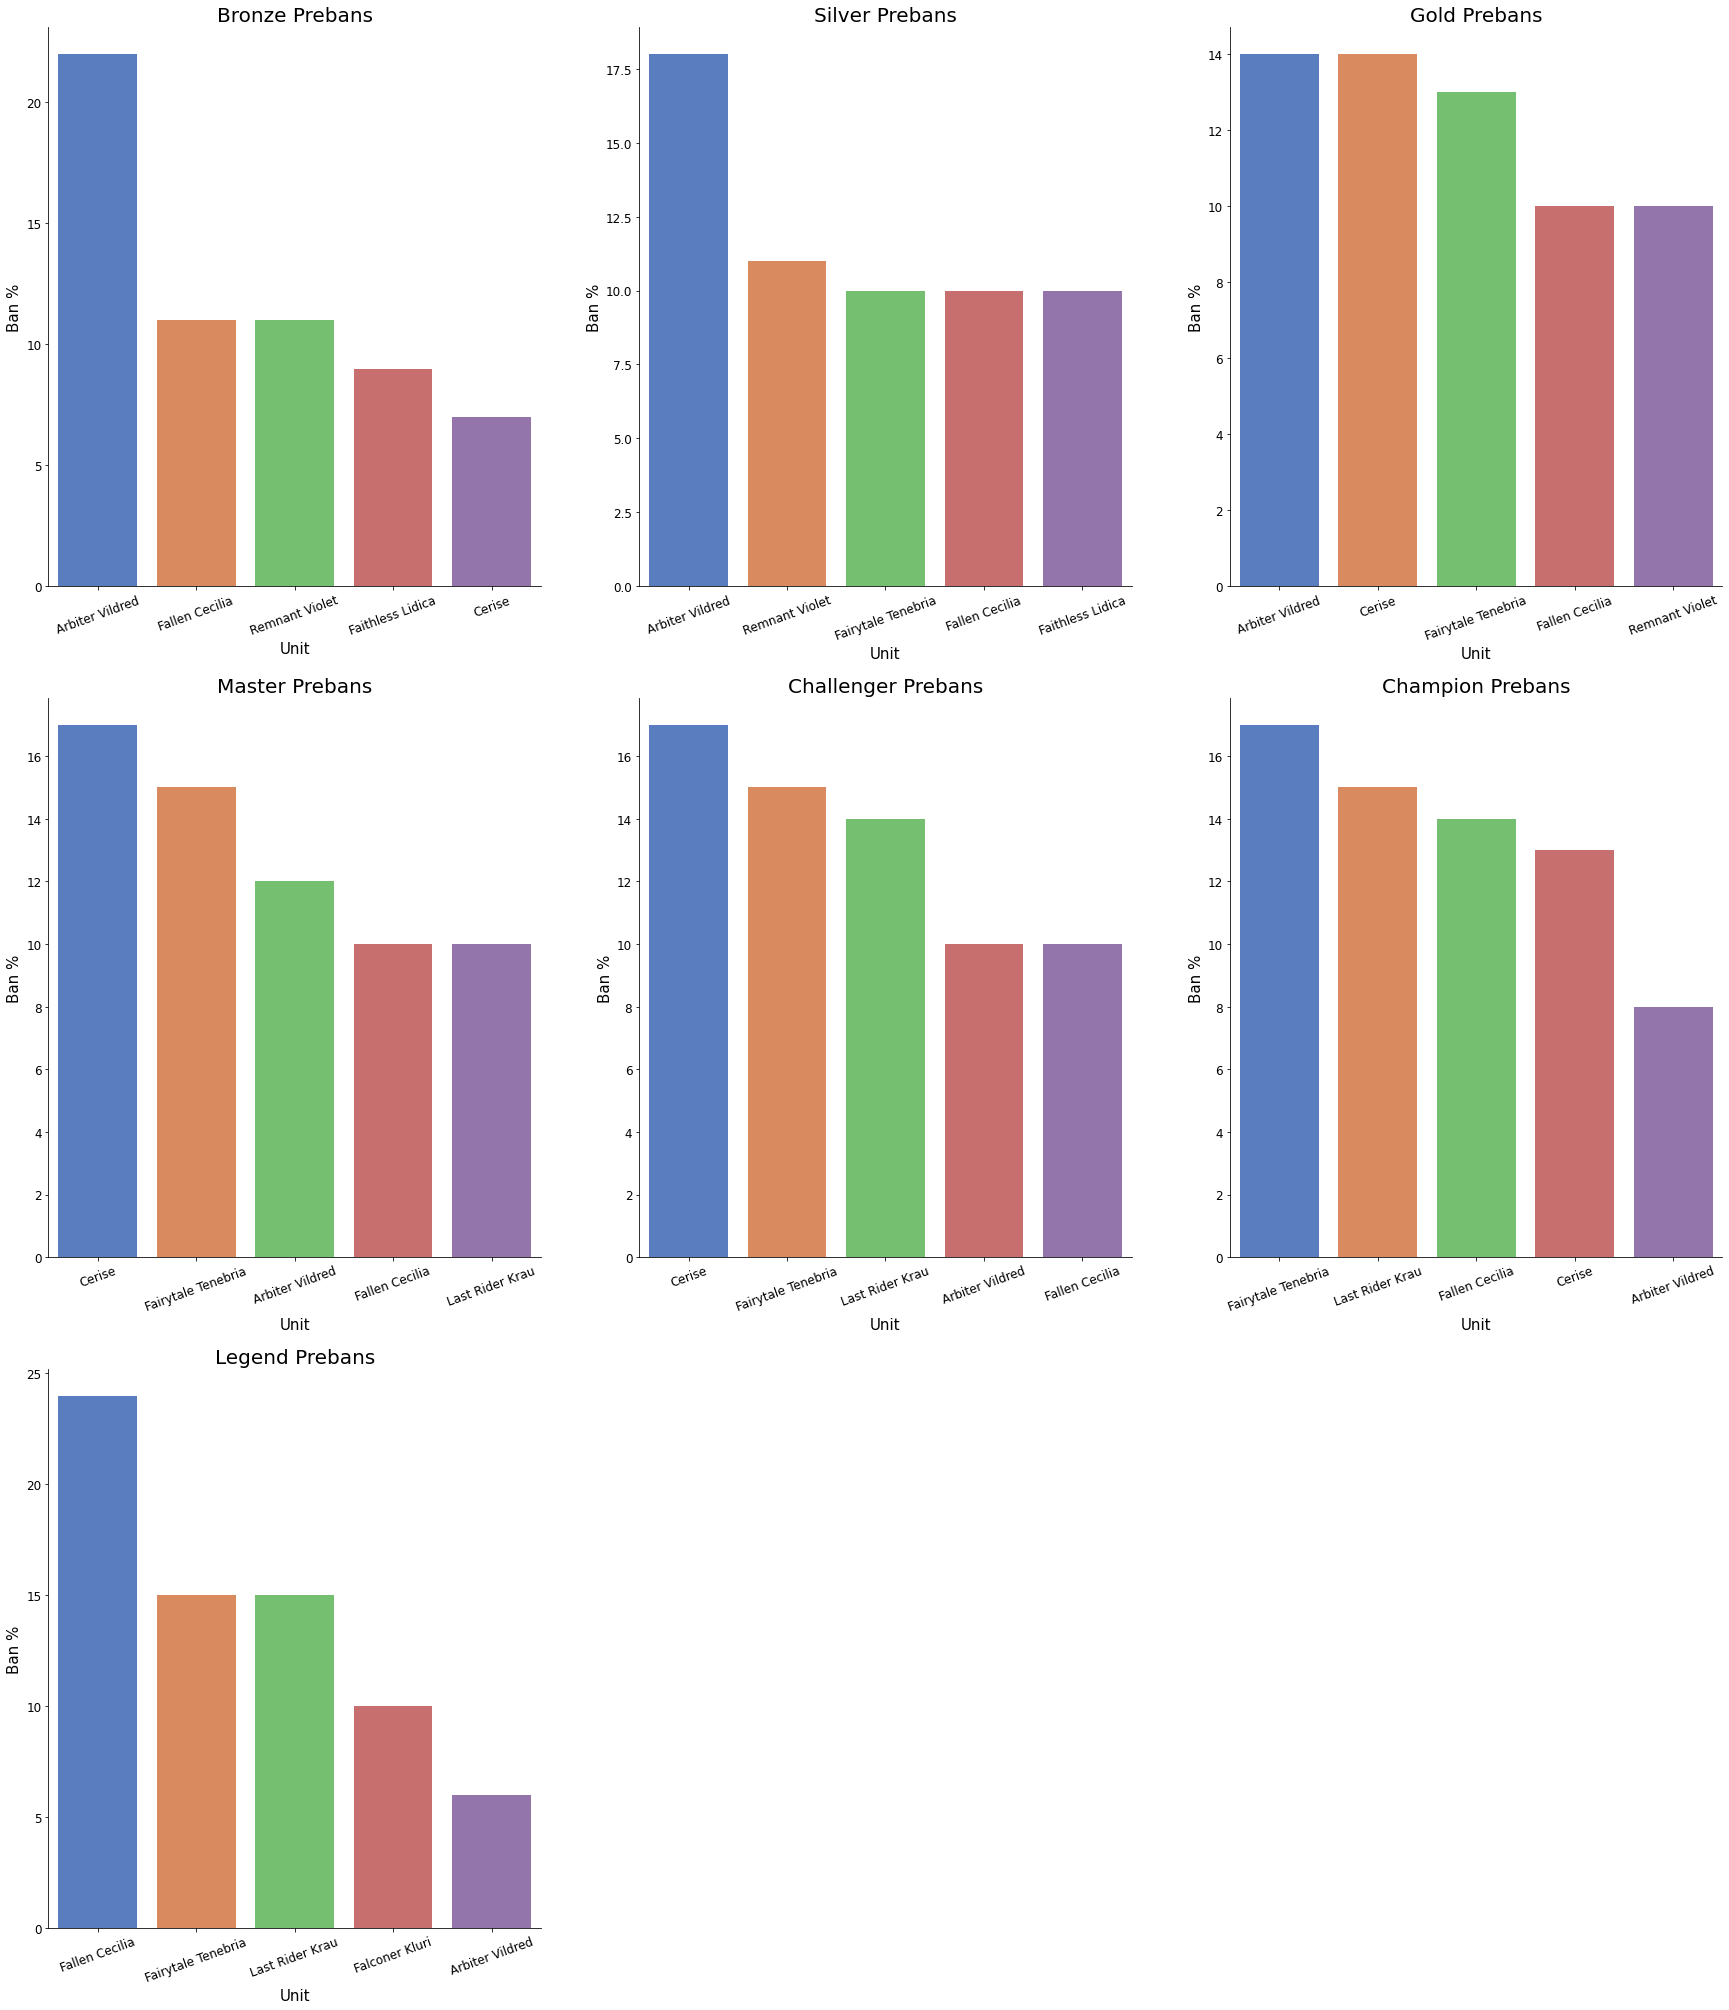

In [37]:
# viz

viz_df = preban_df.copy()

for c in [i for i in viz_df.columns if "pct" in i]:
    viz_df[c] = round(viz_df[c] * 100, 0)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette("muted")

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(30,30))
fig.subplots_adjust(bottom=0)

row=0
col=0
for l in leagues:
    y = f"{l}_preban_pct"
    bar = sns.barplot(x="Unit", 
                y=y, 
                data=viz_df.sort_values(y, ascending=False).head(5).reset_index(),
                ax=axs[row][col])
    bar.set_title(f"{l} prebans".title(), fontsize=20)
    bar.set_ylabel("Ban %", fontsize=15)
    bar.set_xlabel("Unit", fontsize=15)
    bar.tick_params(labelsize=12)
    sns.despine()
    for item in bar.get_xticklabels():
        item.set_rotation(20)
    if col>1:
        col=0
        row+=1
    else:
        col+=1

fig.delaxes(axs[2][1])
fig.delaxes(axs[2][2])

In [38]:
fig.savefig("prebans.jpeg", transparent=False, bbox_inches ="tight")

In [39]:
preban_df.to_csv("preban_by_league.csv")